In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas
import math
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, GRU, LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

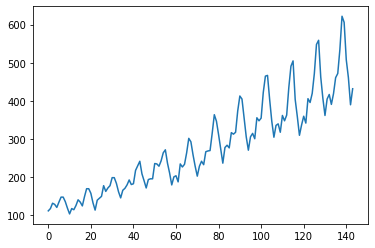

In [2]:
dataframe = pandas.read_csv('data/airline-passengers.csv', usecols=[1], engine='python')
plt.plot(dataframe)
plt.show()

In [3]:
array = dataframe['Passengers'].to_numpy().astype('float32')
n_samples = len(array)
array

array([112., 118., 132., 129., 121., 135., 148., 148., 136., 119., 104.,
       118., 115., 126., 141., 135., 125., 149., 170., 170., 158., 133.,
       114., 140., 145., 150., 178., 163., 172., 178., 199., 199., 184.,
       162., 146., 166., 171., 180., 193., 181., 183., 218., 230., 242.,
       209., 191., 172., 194., 196., 196., 236., 235., 229., 243., 264.,
       272., 237., 211., 180., 201., 204., 188., 235., 227., 234., 264.,
       302., 293., 259., 229., 203., 229., 242., 233., 267., 269., 270.,
       315., 364., 347., 312., 274., 237., 278., 284., 277., 317., 313.,
       318., 374., 413., 405., 355., 306., 271., 306., 315., 301., 356.,
       348., 355., 422., 465., 467., 404., 347., 305., 336., 340., 318.,
       362., 348., 363., 435., 491., 505., 404., 359., 310., 337., 360.,
       342., 406., 396., 420., 472., 548., 559., 463., 407., 362., 405.,
       417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.], dtype=float32)

In [4]:
scaler = MinMaxScaler(feature_range=(0,1))
normalized_array = scaler.fit_transform(array.reshape(-1, 1)).reshape(-1)
normalized_array

array([0.01544401, 0.02702703, 0.05405405, 0.04826255, 0.03281853,
       0.05984557, 0.08494207, 0.08494207, 0.06177607, 0.02895753,
       0.        , 0.02702703, 0.02123553, 0.04247104, 0.07142857,
       0.05984557, 0.04054055, 0.08687258, 0.12741312, 0.12741312,
       0.10424709, 0.05598456, 0.01930502, 0.06949806, 0.07915059,
       0.08880308, 0.14285713, 0.11389962, 0.13127413, 0.14285713,
       0.18339768, 0.18339768, 0.15444016, 0.11196911, 0.08108109,
       0.1196911 , 0.12934363, 0.14671814, 0.17181468, 0.14864865,
       0.15250966, 0.22007722, 0.24324325, 0.26640925, 0.2027027 ,
       0.16795367, 0.13127413, 0.17374519, 0.17760617, 0.17760617,
       0.25482625, 0.25289574, 0.24131274, 0.26833975, 0.3088803 ,
       0.32432434, 0.25675675, 0.20656371, 0.14671814, 0.18725869,
       0.19305018, 0.16216215, 0.25289574, 0.23745173, 0.25096524,
       0.3088803 , 0.38223937, 0.36486486, 0.2992278 , 0.24131274,
       0.1911197 , 0.24131274, 0.26640925, 0.24903473, 0.31467

In [5]:
# split into train and test sets
train_size = int(n_samples * 0.67)
test_size = n_samples - train_size
train, test = normalized_array[:train_size], normalized_array[train_size:]
print(len(train), len(test))

96 48


In [6]:
def rolling_window(a: np.array, window: int) -> np.array:
    shape = a.shape[:-1] + (a.shape[-1] - window + 1, window)
    strides = a.strides + (a.strides[-1],)
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

In [7]:
input_size = 12
train_x_2d = rolling_window(train, input_size)[:-1]  # We don't have the label for the last sequence so we discard it
test_x_2d = rolling_window(test, input_size)[:-1]
# reshape input to be [samples, time steps, features]
train_x_3d = np.reshape(train_x_2d, (train_x_2d.shape[0], train_x_2d.shape[1], 1))
test_x_3d = np.reshape(test_x_2d, (test_x_2d.shape[0], test_x_2d.shape[1], 1))
print(len(train_x_2d), len(test_x_2d))

84 36


In [8]:
train_y = train[input_size:]
test_y = test[input_size:]
print(len(train_y), len(test_y))

84 36


In [9]:
def evaluate_model(model, input_3d=True):
    if input_3d:
        train_x = train_x_3d
        test_x = test_x_3d
    else:
        train_x = train_x_2d
        test_x = test_x_2d
    
    # make predictions
    train_predict = scaler.inverse_transform(model.predict(train_x, batch_size=1))
    test_predict = scaler.inverse_transform(model.predict(test_x, batch_size=1))
    train_y_inverted = scaler.inverse_transform([train_y])
    test_y_inverted = scaler.inverse_transform([test_y])
    # calculate root mean squared error
    train_rmse = math.sqrt(mean_squared_error(train_y_inverted[0], train_predict[:,0]))
    print('Train Score: %.2f RMSE' % (train_rmse))
    test_rmse = math.sqrt(mean_squared_error(test_y_inverted[0], test_predict[:,0]))
    print('Test Score: %.2f RMSE' % (test_rmse))
    train_predict_plot = np.empty_like(array.reshape(-1, 1))
    train_predict_plot[:, :] = np.nan
    train_predict_plot[input_size:len(train_predict)+input_size, :] = train_predict
    # shift test predictions for plotting
    test_predict_plot = np.empty_like(array.reshape(-1, 1))
    test_predict_plot[:, :] = np.nan
    test_predict_plot[len(train_predict)+(input_size*2):len(array), :] = test_predict
    return train_predict_plot, test_predict_plot

In [10]:
nonrecs = [None for _ in range(0, 4)]
nonrec_names = ["" for _ in range(0, 4)]

simple_rnns = [None for _ in range(0, 4)]
simple_rnn_names = ["" for _ in range(0, 4)]

grus = [None for _ in range(0, 4)]
gru_names = ["" for _ in range(0, 4)]

lstms = [None for _ in range(0, 4)]
lstm_names = ["" for _ in range(0, 4)]

In [11]:
nonrec_names[0] = "Non-recurrent 1: Linear with bias"
nonrecs[0] = Sequential()
nonrecs[0].add(Dense(1))
nonrecs[0].compile(loss='mean_squared_error', optimizer='adam')
nonrecs[0].fit(train_x_2d, train_y, epochs=500, batch_size=1, verbose=0)

In [12]:
nonrec_names[1] = "Non-recurrent 2: 1 hidden layer with 10 neurons, ReLU"
nonrecs[1] = Sequential()
nonrecs[1].add(Dense(10, activation='relu'))
nonrecs[1].add(Dense(1))
nonrecs[1].compile(loss='mean_squared_error', optimizer='adam')
nonrecs[1].fit(train_x_2d, train_y, epochs=500, batch_size=1, verbose=0)

In [13]:
nonrec_names[2] = "Non-recurrent 3: 2 hidden layers with 10 neurons, ReLU"
nonrecs[2] = Sequential()
nonrecs[2].add(Dense(10, activation='relu'))
nonrecs[2].add(Dense(10, activation='relu'))
nonrecs[2].add(Dense(1))
nonrecs[2].compile(loss='mean_squared_error', optimizer='adam')
nonrecs[2].fit(train_x_2d, train_y, epochs=500, batch_size=1, verbose=0)

In [14]:
nonrec_names[3] = "Non-recurrent 4: 3 hidden layers with 25 neurons, ReLU"
nonrecs[3] = Sequential()
nonrecs[3].add(Dense(25, activation='relu'))
nonrecs[3].add(Dense(25, activation='relu'))
nonrecs[3].add(Dense(25, activation='relu'))
nonrecs[3].add(Dense(1))
nonrecs[3].compile(loss='mean_squared_error', optimizer='adam')
nonrecs[3].fit(train_x_2d, train_y, epochs=500, batch_size=1, verbose=0)

In [15]:
simple_rnn_names[0] = "Simple RNN 1: Shallow narrow (1 Simple RNN layer with 1 unit)"
simple_rnns[0] = Sequential()
simple_rnns[0].add(SimpleRNN(1))
simple_rnns[0].compile(loss='mean_squared_error', optimizer='adam')
simple_rnns[0].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [16]:
simple_rnn_names[1] = "Simple RNN 2: Shallow wide (1 hidden Simple RNN layer with 10 units)"
simple_rnns[1] = Sequential()
simple_rnns[1].add(SimpleRNN(10))
simple_rnns[1].add(Dense(1))
simple_rnns[1].compile(loss='mean_squared_error', optimizer='adam')
simple_rnns[1].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [17]:
simple_rnn_names[2] = "Simple RNN 3: Stacked narrow (2 Simple RNN layers with 1 unit)"
simple_rnns[2] = Sequential()
simple_rnns[2].add(SimpleRNN(1, return_sequences=True))
simple_rnns[2].add(SimpleRNN(1))
simple_rnns[2].compile(loss='mean_squared_error', optimizer='adam')
simple_rnns[2].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [18]:
simple_rnn_names[3] = "Simple RNN 4: Stacked wide (2 hidden Simple RNN layers with 10 units)"
simple_rnns[3] = Sequential()
simple_rnns[3].add(SimpleRNN(10, return_sequences=True))
simple_rnns[3].add(SimpleRNN(10))
simple_rnns[3].add(Dense(1))
simple_rnns[3].compile(loss='mean_squared_error', optimizer='adam')
simple_rnns[3].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [19]:
gru_names[0] = "GRU 1: Shallow narrow (1 hidden GRU layer with 1 unit)"
grus[0] = Sequential()
grus[0].add(GRU(1))
grus[0].add(Dense(1))
grus[0].compile(loss='mean_squared_error', optimizer='adam')
grus[0].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [20]:
gru_names[1] = "GRU 2: Shallow wide (1 hidden GRU layer with 10 units)"
grus[1] = Sequential()
grus[1].add(GRU(10))
grus[1].add(Dense(1))
grus[1].compile(loss='mean_squared_error', optimizer='adam')
grus[1].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [21]:
gru_names[2] = "GRU 3: Stacked narrow (2 hidden GRU layers with 1 unit)"
grus[2] = Sequential()
grus[2].add(GRU(1, return_sequences=True))
grus[2].add(GRU(1))
grus[2].add(Dense(1))
grus[2].compile(loss='mean_squared_error', optimizer='adam')
grus[2].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [22]:
gru_names[3] = "GRU 4: Stacked wide (2 hidden GRU layers with 10 units)"
grus[3] = Sequential()
grus[3].add(GRU(10, return_sequences=True))
grus[3].add(GRU(10))
grus[3].add(Dense(1))
grus[3].compile(loss='mean_squared_error', optimizer='adam')
grus[3].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [23]:
lstm_names[0] = "LSTM 1: Shallow narrow (1 hidden LSTM layer with 1 unit)"
lstms[0] = Sequential()
lstms[0].add(LSTM(1))
lstms[0].add(Dense(1))
lstms[0].compile(loss='mean_squared_error', optimizer='adam')
lstms[0].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [24]:
lstm_names[1] = "LSTM 2: Shallow wide (1 hidden LSTM layer with 10 units)"
lstms[1] = Sequential()
lstms[1].add(LSTM(10))
lstms[1].add(Dense(1))
lstms[1].compile(loss='mean_squared_error', optimizer='adam')
lstms[1].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [25]:
lstm_names[2] = "LSTM 3: Stacked narrow (2 hidden LSTM layers with 1 unit)"
lstms[2] = Sequential()
lstms[2].add(LSTM(1, return_sequences=True))
lstms[2].add(LSTM(1))
lstms[2].add(Dense(1))
lstms[2].compile(loss='mean_squared_error', optimizer='adam')
lstms[2].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [26]:
lstm_names[3] = "LSTM 4: Stacked wide (2 hidden LSTM layers with 10 units)"
lstms[3] = Sequential()
lstms[3].add(LSTM(10, return_sequences=True))
lstms[3].add(LSTM(10))
lstms[3].add(Dense(1))
lstms[3].compile(loss='mean_squared_error', optimizer='adam')
lstms[3].fit(train_x_3d, train_y, epochs=500, batch_size=1, verbose=0)

In [27]:
print("Non-recurrent models' performance:")
train_predict_plots_nonrec, test_predict_plots_nonrec = [], []
for model, title in zip(nonrecs, nonrec_names):
    print('\n' + title)
    train_predict_plot, test_predict_plot = evaluate_model(model, input_3d=False)
    train_predict_plots_nonrec.append(train_predict_plot)
    test_predict_plots_nonrec.append(test_predict_plot)
    
print("\n\n\nSimple RNNs' performance:")
train_predict_plots_simple_rnn, test_predict_plots_simple_rnn = [], []
for model, title in zip(simple_rnns, simple_rnn_names):
    print('\n' + title)
    train_predict_plot, test_predict_plot = evaluate_model(model, input_3d=True)
    train_predict_plots_simple_rnn.append(train_predict_plot)
    test_predict_plots_simple_rnn.append(test_predict_plot)
    
print("\n\n\nGRUs' performance:")
train_predict_plots_gru, test_predict_plots_gru = [], []
for model, title in zip(grus, gru_names):
    print('\n' + title)
    train_predict_plot, test_predict_plot = evaluate_model(model, input_3d=True)
    train_predict_plots_gru.append(train_predict_plot)
    test_predict_plots_gru.append(test_predict_plot)

print("\n\n\nLSTMs' performance:")
train_predict_plots_lstm, test_predict_plots_lstm = [], []
for model, title in zip(lstms, lstm_names):
    print('\n' + title)
    train_predict_plot, test_predict_plot = evaluate_model(model, input_3d=True)
    train_predict_plots_lstm.append(train_predict_plot)
    test_predict_plots_lstm.append(test_predict_plot)

Non-recurrent models' performance:

Non-recurrent 1: Linear with bias
Train Score: 11.99 RMSE
Test Score: 31.05 RMSE

Non-recurrent 2: 1 hidden layer with 10 neurons, ReLU
Train Score: 7.76 RMSE
Test Score: 17.94 RMSE

Non-recurrent 3: 2 hidden layers with 10 neurons, ReLU
Train Score: 6.86 RMSE
Test Score: 20.88 RMSE

Non-recurrent 4: 3 hidden layers with 25 neurons, ReLU
Train Score: 7.11 RMSE
Test Score: 35.44 RMSE



Simple RNNs' performance:

Simple RNN 1: Shallow narrow (1 Simple RNN layer with 1 unit)
Train Score: 26.58 RMSE
Test Score: 75.84 RMSE

Simple RNN 2: Shallow wide (1 hidden Simple RNN layer with 10 units)
Train Score: 10.42 RMSE
Test Score: 106.31 RMSE

Simple RNN 3: Stacked narrow (2 Simple RNN layers with 1 unit)
Train Score: 22.75 RMSE
Test Score: 68.53 RMSE

Simple RNN 4: Stacked wide (2 hidden Simple RNN layers with 10 units)
Train Score: 7.67 RMSE
Test Score: 98.92 RMSE



GRUs' performance:

GRU 1: Shallow narrow (1 hidden GRU layer with 1 unit)
Train Score: 24

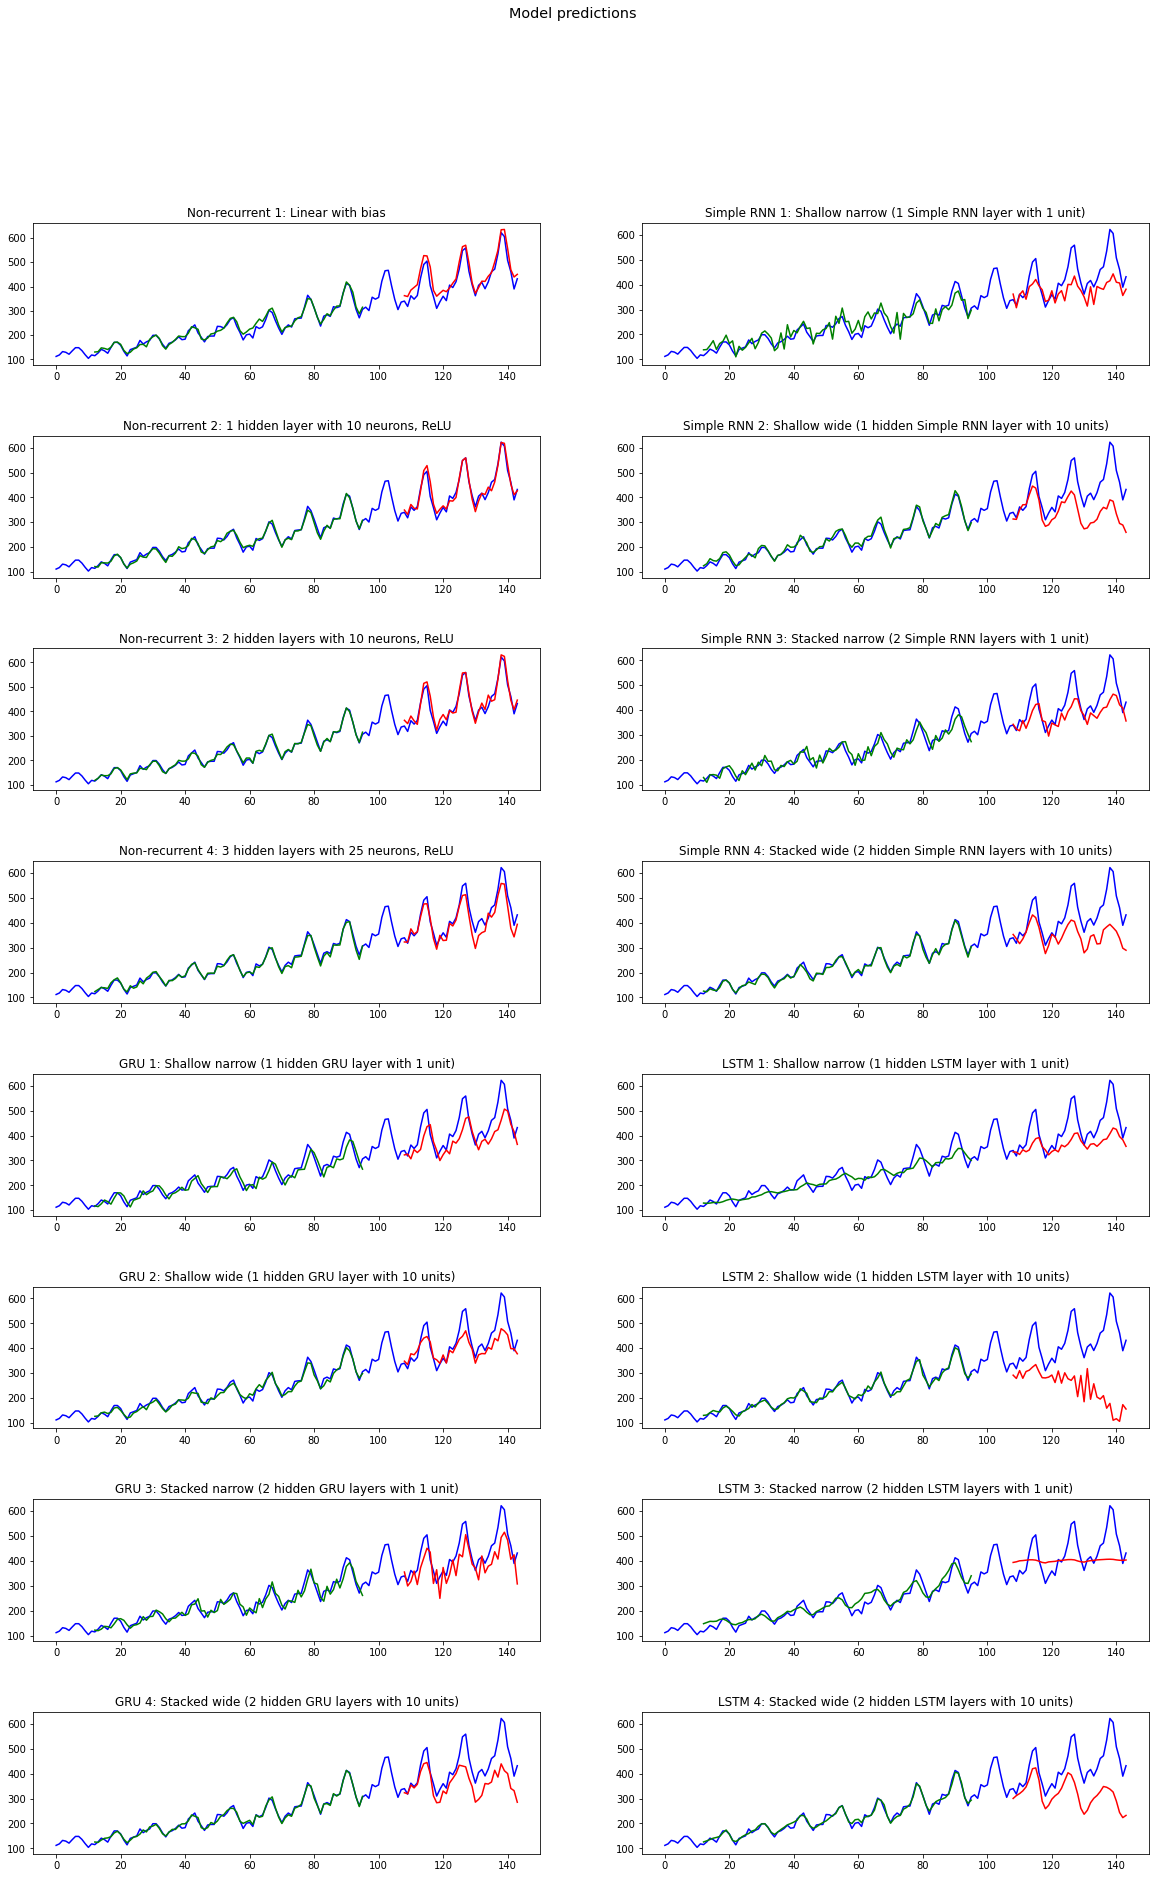

In [28]:
fig, axs = plt.subplots(8, 2, figsize=(20, 30), gridspec_kw={'hspace': 0.5})
fig.suptitle('Model predictions', size='x-large')

ground_truth_color = 'blue'
train_predict_color = 'green'
test_predict_color = 'red'

for i in range(0, 4):
    axs[i, 0].plot(array, color=ground_truth_color)
    axs[i, 0].plot(train_predict_plots_nonrec[i], color=train_predict_color)
    axs[i, 0].plot(test_predict_plots_nonrec[i], color=test_predict_color)
    axs[i, 0].set_title(nonrec_names[i])
    
for i in range(0, 4):
    axs[i, 1].plot(array, color=ground_truth_color)
    axs[i, 1].plot(train_predict_plots_simple_rnn[i], color=train_predict_color)
    axs[i, 1].plot(test_predict_plots_simple_rnn[i], color=test_predict_color)
    axs[i, 1].set_title(simple_rnn_names[i])
    
for i in range(0, 4):
    axs[4+i, 0].plot(array, color=ground_truth_color)
    axs[4+i, 0].plot(train_predict_plots_gru[i], color=train_predict_color)
    axs[4+i, 0].plot(test_predict_plots_gru[i], color=test_predict_color)
    axs[4+i, 0].set_title(gru_names[i])
    
for i in range(0, 4):
    axs[4+i, 1].plot(array, color=ground_truth_color)
    axs[4+i, 1].plot(train_predict_plots_lstm[i], color=train_predict_color)
    axs[4+i, 1].plot(test_predict_plots_lstm[i], color=test_predict_color)
    axs[4+i, 1].set_title(lstm_names[i])

plt.show()